In [2]:
import torch
import torch.nn as nn
from torchvision.transforms import ToTensor

import pandas as pd

from tqdm import tqdm

import matplotlib.pyplot as plt
from PIL import Image

from random import randint

In [3]:
device = torch.device("cuda")
device

device(type='cuda')

In [4]:
labels_pd = pd.read_csv("../dataset/train/training.csv")[["left_eye_center_x","left_eye_center_y", "right_eye_center_x", "right_eye_center_y"]]

labels = labels_pd.to_numpy()

labels_pd.columns, labels.shape

(Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
        'right_eye_center_y'],
       dtype='object'),
 (7049, 4))

In [5]:
img = Image.open("../dataset/train/train_images/0.jpg")
t = ToTensor()
t(img).shape

torch.Size([3, 96, 96])

In [6]:
class Inception(nn.Module):
    # output channels 
    def __init__(self, in_channels: int, bc1: int, bc2: [], bc3: [], bc4: int):
        super().__init__()
        self.b1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=bc1, kernel_size=1),
            # nn.BatchNorm2d(bc1),
            nn.ReLU()
        )
        self.b2 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=bc2[0], kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=bc2[0], out_channels=bc2[1], kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.b3 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=bc3[0], kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=bc3[0], out_channels=bc3[1], kernel_size=5, padding=2),
            nn.ReLU(),
        )
        self.b4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels=in_channels, out_channels=bc4, kernel_size=1)
        )

    def forward(self, x):
        return torch.concat(
            (self.b1(x), self.b2(x), self.b3(x), self.b4(x)),
            dim=1
        )
     
class MiniGoogLeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=12, kernel_size=1, stride=1),
            # nn.ReLU(),
            nn.ReLU(),
            
            Inception(12, 32, [16, 32], [16, 32], 32),
            nn.MaxPool2d(kernel_size=2, stride=2), # 32x4 x48x48

            Inception(32*4, 64, [48, 64], [48, 64], 64),
            nn.MaxPool2d(kernel_size=2, stride=2), # 64x4 x24x24

            Inception(64*4, 32, [48, 32], [48, 32], 32),
            nn.MaxPool2d(kernel_size=2, stride=2), # 32x4 x12x12
            
            # Inception(32*4, 16, [24, 16], [24, 16], 24),
            
            # nn.MaxPool2d(kernel_size=2, stride=2), # 16x4 x6x6


            nn.Conv2d(in_channels=32*4, out_channels=36, kernel_size=1, stride=1),
            # nn.BatchNorm2d(36),
            
            nn.Conv2d(in_channels=36, out_channels=8, kernel_size=1, stride=1),
            # nn.BatchNorm2d(8),

            nn.Conv2d(in_channels=8, out_channels=3, kernel_size=1, stride=1),
            # nn.BatchNorm2d(3),
            
            nn.Flatten(),
            nn.Linear(in_features=3*12*12, out_features=4)
        )
    def forward(self, x):
        return self.layer_stack(x)

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([5, 3, 96, 96]) torch.Size([5, 4])
torch.Size([5, 3, 96, 96])
torch.Size([5, 4])
torch.Size([5, 4])


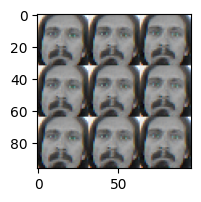

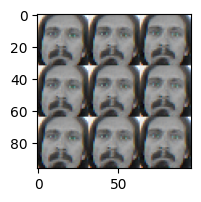

In [7]:
def load_batch(batch_i, BS, train=True):
    if train:
        dataset_path = "../dataset/train/train_images/"
    else:
        dataset_path = "../dataset/test/test_images/"

    image_names = [dataset_path+str(i)+".jpg" for i in range(batch_i, batch_i+BS)]

    image_tensor = torch.Tensor(size=[BS, 3, 96, 96])

    for i, name in enumerate(image_names):
        image_tensor[i] = t(Image.open(name))

    image_labels = t(labels[batch_i:batch_i+BS]).squeeze()

    return image_tensor, image_labels

x, y = load_batch(0, 5)
plt.figure(figsize=(2,2))
plt.imshow(t(img).reshape(96, 96, 3))
plt.figure(figsize=(2,2))
plt.imshow(x[0].reshape(96, 96, 3))

print(type(x), type(y), x.shape, y.shape)

model = MiniGoogLeNet()
model = model.to(torch.device("cpu"))
batch = x[0:5]
print(batch.shape)
print(model(batch).shape)
print(y.shape)


In [8]:
model = MiniGoogLeNet()
model = model.to(device).type(torch.double)

In [11]:
BS = 32
LR = 0.0001
N_EPOCHS = 5

loss_fn = nn.MSELoss()

optim = torch.optim.SGD(params=model.parameters(), lr=LR)

losses = []

N_SAMPLES = 7048
N_BATCHES = int(N_SAMPLES/BS)

prog = tqdm(range(N_EPOCHS))

for epoch in prog:

    for batch in range(N_BATCHES):

        optim.zero_grad()

        # get batch
        batch_i = randint(0, N_SAMPLES-BS)
        x, y = load_batch(batch_i, BS, train=True)
        print(y.shape)
        x = x.to(device).type(torch.double)
        y = y.to(device).type(torch.double)
        print(y.shape)
        print(loss.shape)

        forward = model(x)
        loss = loss_fn(forward, y)

        losses.append(loss.detach().cpu().item()/torch.Tensor([64]).type(torch.double))

        loss.backward()
        optim.step()

        # prog.set_description(f"Loss: {losses[len(losses)-1]}")
        print(f"Loss: {[loss.detach().cpu().item()/torch.Tensor([64]).type(torch.double), loss.detach().item()]}")

  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([])
Loss: [tensor([31.5684], dtype=torch.float64), 2020.3791385476757]
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([])
Loss: [tensor([30.2386], dtype=torch.float64), 1935.269843855489]
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([])
Loss: [tensor([31.3612], dtype=torch.float64), 2007.1194328438123]
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([])


  0%|          | 0/5 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# eval_batch, _ = load_batch(0, 1782, train=False)
# eval_out = model(eval_batch)



: 

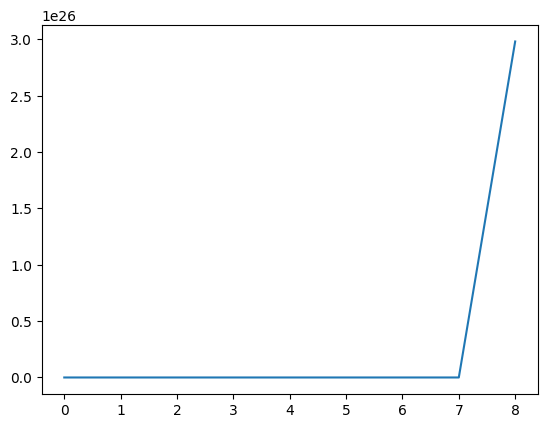

In [ ]:
plt.plot(losses)

12
tensor([66.5747, 37.3080, 30.4453, 37.3080], dtype=torch.float64)
[[78.40709056 44.8207268  37.7577526  46.54338406]]


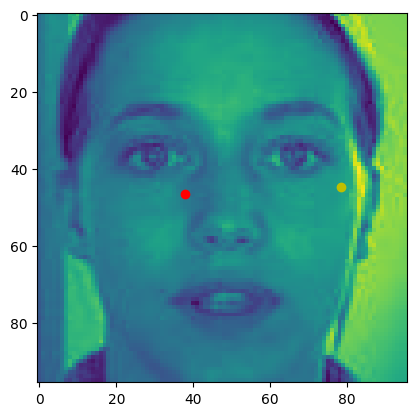

In [ ]:
i = randint(0, 1000)
# i = 852
print(i)
x, y = load_batch(i, 1)
plt.imshow(x[0][0])

model_2 = model.to(torch.device("cpu"))
model_2 = model_2.type(torch.double)
preds = model_2(x.type(torch.double)).detach().numpy()
left = preds[0,:2]
right = preds[0,2:]
plt.scatter(*left, c='y')
plt.scatter(*right, c='r')

print(y)
print(preds)